# Dropout prediction and rule mining for Sozialwissenschaften

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/sw_first_modules_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df


,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,EVBestanden,EVVersuche,EVNote,PolitBestanden,PolitVersuche,PolitNote,SoziBestanden,SoziVersuche,SoziNote,MedienBestanden,MedienVersuche,MedienNote,Dropout
0,1982,weiblich,0,25,0,0,5.0,0,0,5.0,1,1,2.3,0,0,5.0,0
1,1982,weiblich,0,25,0,0,5.0,0,0,5.0,1,1,3.7,1,2,4.0,0
2,1985,männlich,1,22,0,0,5.0,0,0,5.0,1,3,4.0,0,0,5.0,1
3,1979,männlich,1,28,0,2,5.0,0,1,5.0,1,1,3.3,1,2,3.3,1
4,1987,weiblich,1,21,0,0,5.0,1,3,4.0,0,0,5.0,0,0,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,1998,männlich,1,20,1,1,2.7,0,1,5.0,1,1,4.0,0,1,5.0,1
1164,1997,weiblich,1,21,1,1,2.7,0,0,5.0,0,0,5.0,0,1,5.0,1
1165,1998,weiblich,1,20,1,2,3.3,0,1,5.0,0,0,5.0,0,1,5.0,1
1166,1998,weiblich,1,20,1,1,3.7,0,0,5.0,0,0,5.0,0,0,5.0,1


In [4]:
def print_metric(cols, df):
    rows = len(df)
    for col in cols:
        count = len(df[df[col]==1])
        print(f"{col}:", count, f"({count*100./rows} %)")

In [5]:
print_metric(["Dropout", "EVBestanden", "PolitBestanden", "SoziBestanden", "MedienBestanden"], df)

Dropout: 381 (32.61986301369863 %)
EVBestanden: 981 (83.98972602739725 %)
PolitBestanden: 871 (74.57191780821918 %)
SoziBestanden: 881 (75.42808219178082 %)
MedienBestanden: 928 (79.45205479452055 %)


In [6]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,EVBestanden,EVVersuche,EVNote,PolitBestanden,PolitVersuche,PolitNote,SoziBestanden,SoziVersuche,SoziNote,MedienBestanden,MedienVersuche,MedienNote,Dropout,Männlich,Weiblich,Divers
0,0,25,0,0,5.0,0,0,5.0,1,1,2.3,0,0,5.0,0,0,1,0
1,0,25,0,0,5.0,0,0,5.0,1,1,3.7,1,2,4.0,0,0,1,0
2,1,22,0,0,5.0,0,0,5.0,1,3,4.0,0,0,5.0,1,1,0,0
3,1,28,0,2,5.0,0,1,5.0,1,1,3.3,1,2,3.3,1,1,0,0
4,1,21,0,0,5.0,1,3,4.0,0,0,5.0,0,0,5.0,1,0,1,0


In [7]:
print_metric(["Männlich", "Weiblich", "Divers"], df_classification)

Männlich: 411 (35.18835616438356 %)
Weiblich: 757 (64.81164383561644 %)
Divers: 0 (0.0 %)


### Training the model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [9]:
def eval_model(clf):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)


In [10]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf)


# Trainset
Balanced accuracy: 0.9459221545489152
Area under curve: 0.9459221545489152
Confusion Matrix (tn, fp, fn, tp):
[[578  14]
 [ 24 260]]
# Testset
Balanced accuracy: 0.7786941580756014
Area under curve: 0.7786941580756014
Confusion Matrix (tn, fp, fn, tp):
[[169  26]
 [ 30  67]]


### Display learned rules

In [11]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

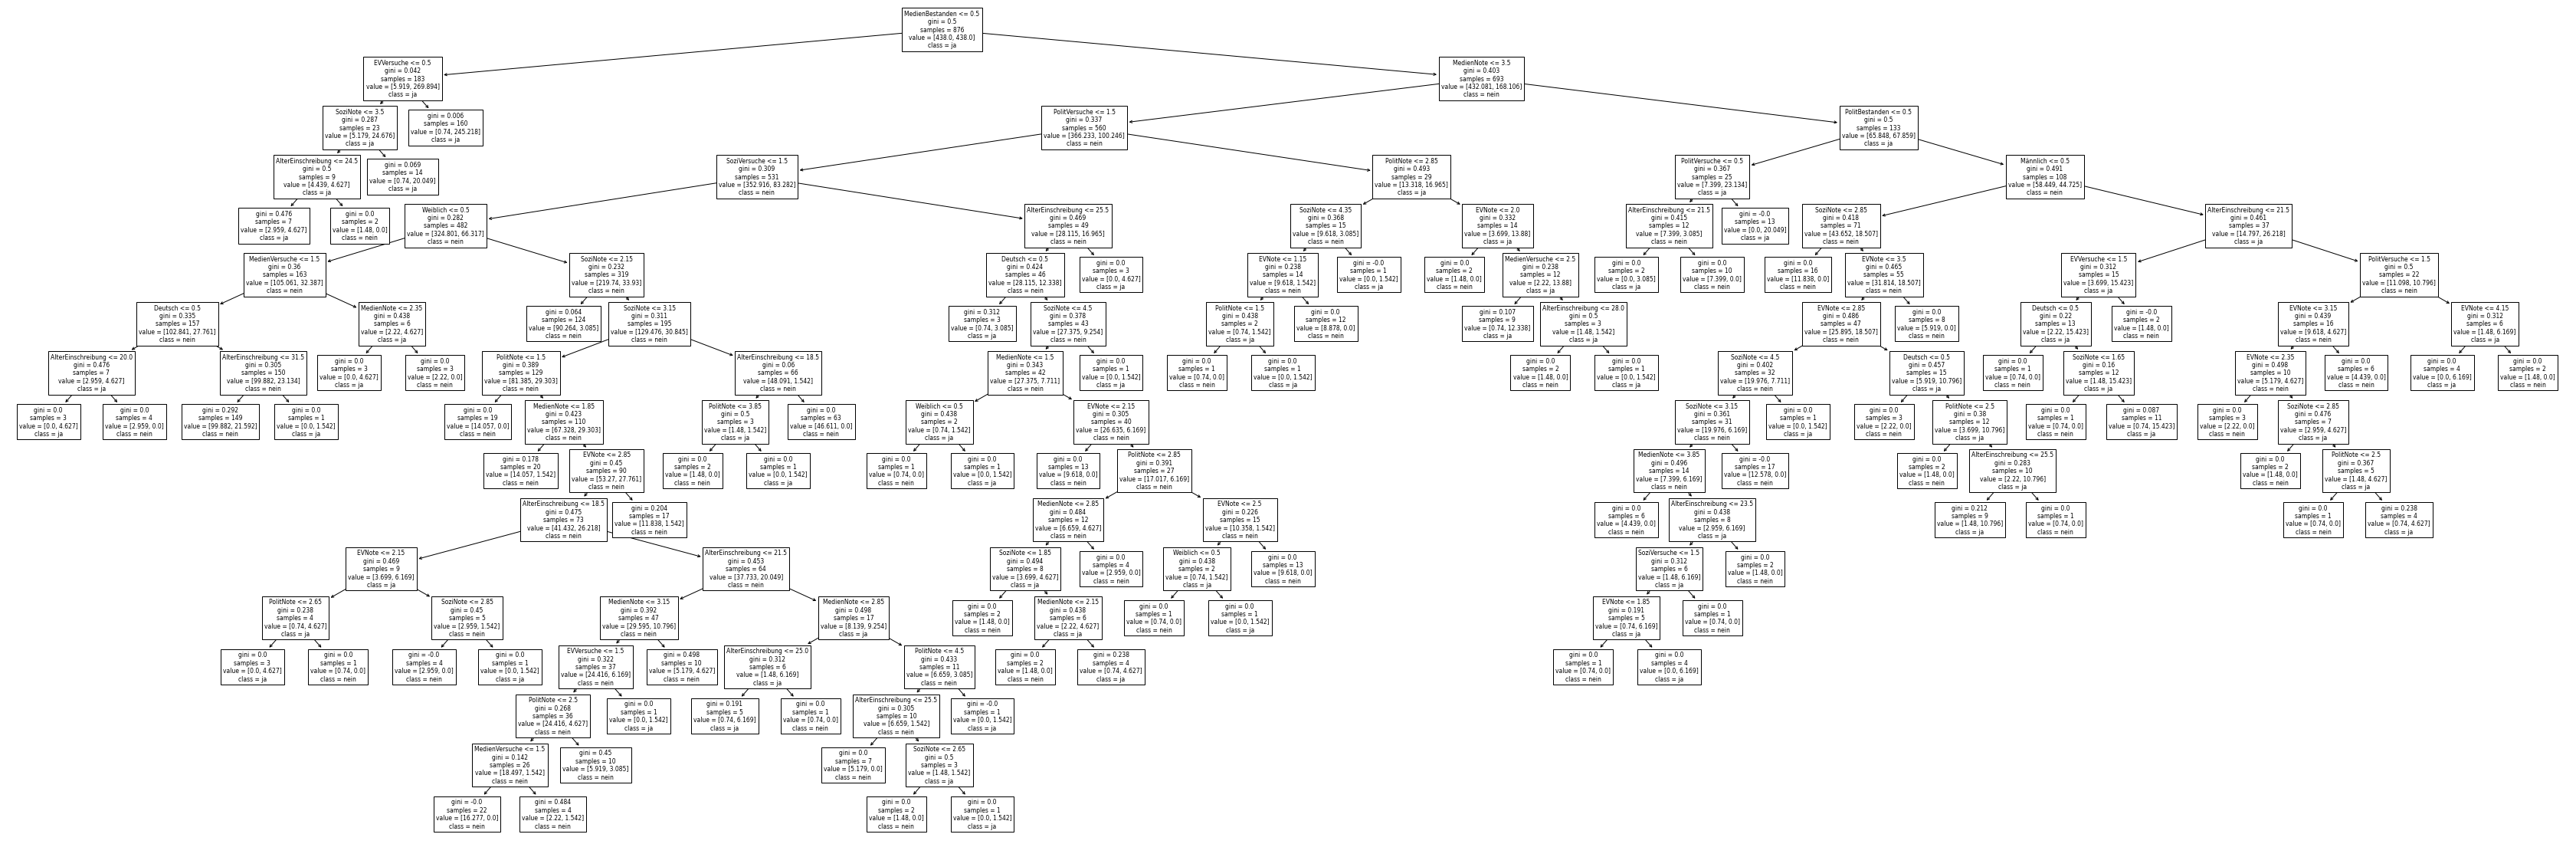

In [12]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Post pruning

In [13]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00105153, 0.00108666, 0.00110342, 0.00114155,
        0.00114155, 0.00114155, 0.0012165 , 0.00123223, 0.0013624 ,
        0.00138765, 0.00140907, 0.00142812, 0.00142948, 0.00145631,
        0.00150972, 0.00155324, 0.00170586, 0.00180008, 0.00184141,
        0.00189299, 0.0019032 , 0.00205321, 0.00208708, 0.00229769,
        0.00229971, 0.00235079, 0.00236896, 0.00238198, 0.00242567,
        0.00243774, 0.00255038, 0.00257653, 0.00268384, 0.00295949,
        0.00334857, 0.00426216, 0.00497018, 0.00503284, 0.00657907,
        0.00674086, 0.00881676, 0.02031595, 0.21047257]),
 'impurities': array([0.08531178, 0.08636332, 0.08853664, 0.08964006, 0.09078161,
        0.09192316, 0.09306472, 0.09428122, 0.09551344, 0.09823824,
        0.10101354, 0.10383169, 0.11382853, 0.11668749, 0.1181438 ,
        0.12116325, 0.12271648, 0.1261282 , 0.12972836, 0.13156978,
        0.13346277, 0.1486884 , 0.15074161, 0.15282869, 0.15512638,
        0.15742609, 0.15977688

Text(0, 0.5, 'Balanced Accuracy scores')

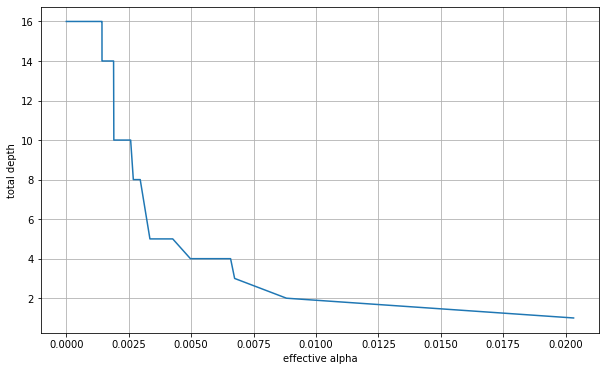

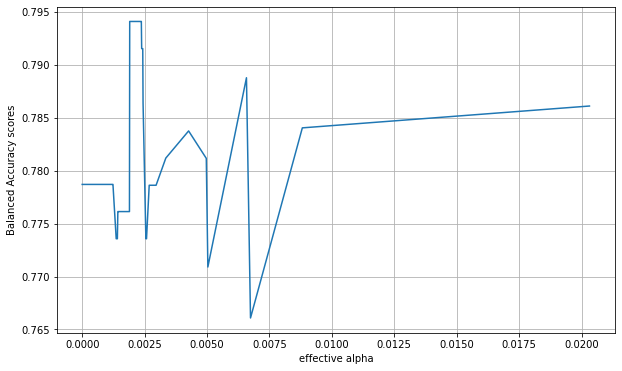

In [15]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.8414303387894937
Area under curve: 0.8414303387894937
Confusion Matrix (tn, fp, fn, tp):
[[546  46]
 [ 68 216]]
# Testset
Balanced accuracy: 0.7708961141950833
Area under curve: 0.7708961141950832
Confusion Matrix (tn, fp, fn, tp):
[[174  21]
 [ 34  63]]


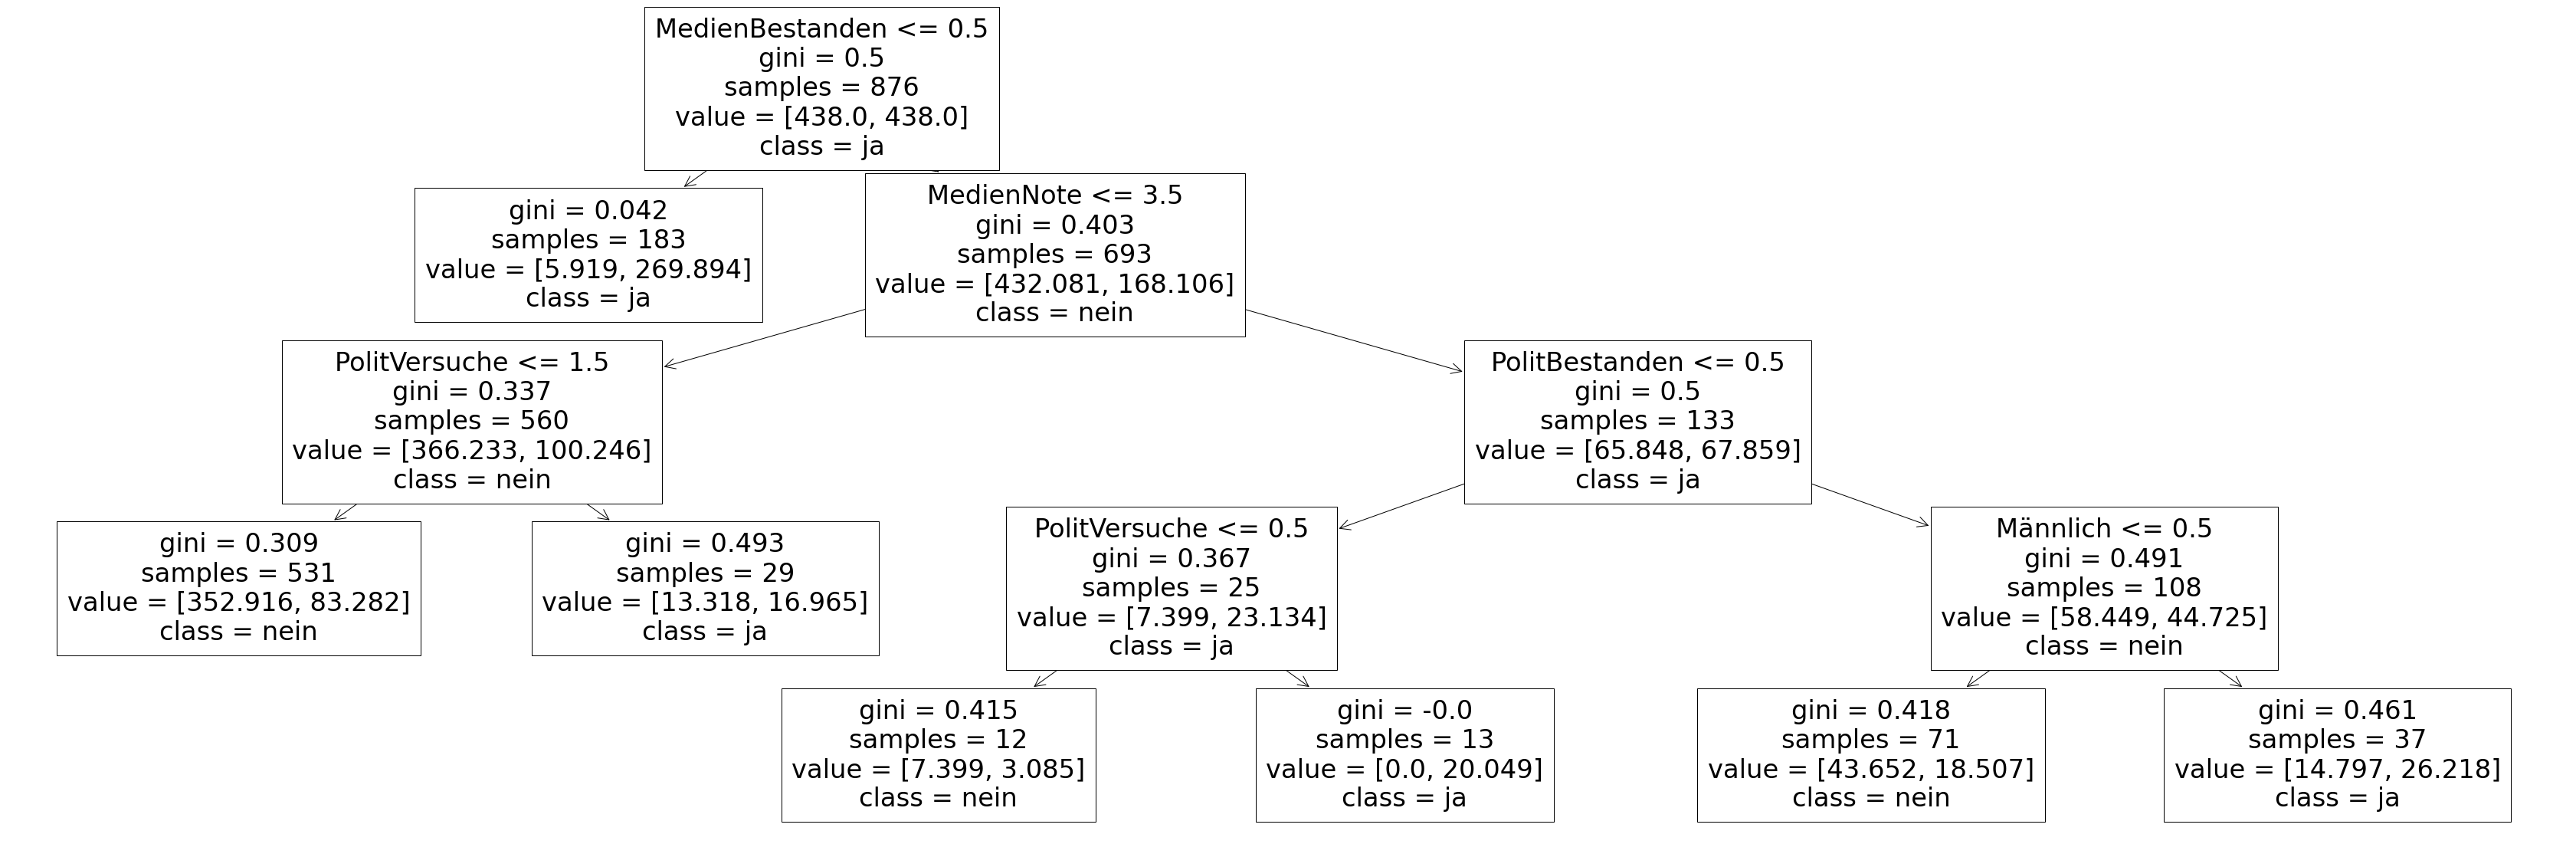

In [16]:
selected_ccp = 0.0065
# selected_ccp = 0.0024  # Alternative alpha with tree-depth 10, see below.


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

# Trainset
Balanced accuracy: 0.8918443090978303
Area under curve: 0.8918443090978302
Confusion Matrix (tn, fp, fn, tp):
[[564  28]
 [ 48 236]]
# Testset
Balanced accuracy: 0.7915146708961143
Area under curve: 0.7915146708961142
Confusion Matrix (tn, fp, fn, tp):
[[174  21]
 [ 30  67]]


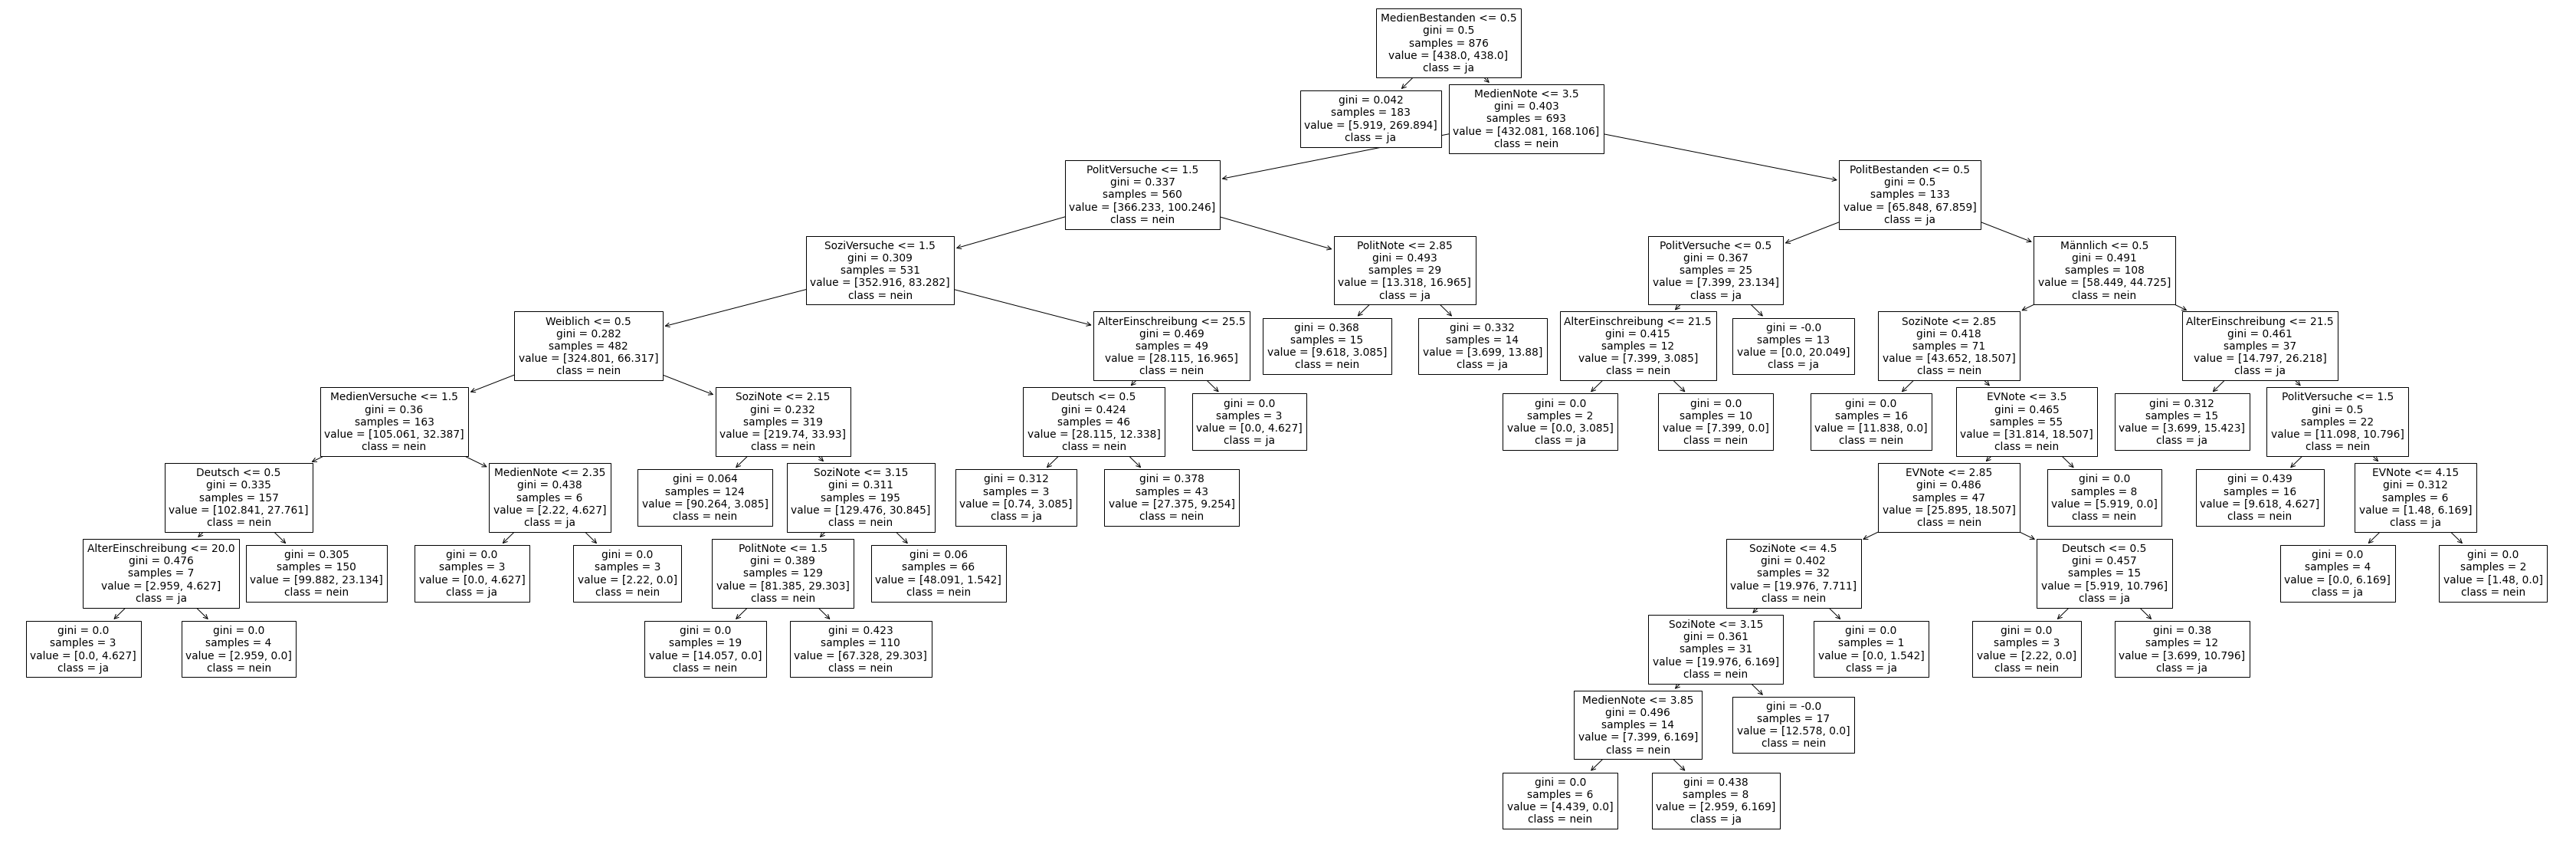

In [17]:
selected_ccp = 0.0024  

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()
